## Load_images

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Activation,MaxPool2D,Reshape,BatchNormalization,LeakyReLU,UpSampling2D,Flatten
from keras.activations import relu
from keras.optimizers import SGD
from keras.datasets import mnist
import math as math
from tqdm import tqdm_notebook as tqdm
from keras import backend as K 
from PIL import Image
import time
K.set_image_dim_ordering('th')

Load Image from NPZ 

In [2]:
f= np.load('omniglot.npz')
images= (f['images'])

Demo a simple image 


size of image is 104 x104


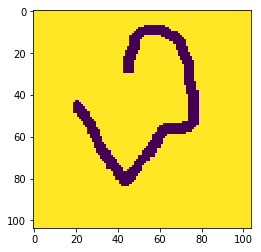

In [3]:
print "size of image is %d x%d" %images[2].shape
plt.imshow(images[2])
plt.show()
plt.close()

Generator 

In [4]:
def generator_model():
    model = Sequential()
    model.add(Dense(512,input_shape=(100,)))
    model.add(Activation('tanh'))
    model.add(Dense(32*13*13))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((32, 13, 13), input_shape=(128*7*7,)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(16, (5, 5), padding='same'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(16, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.summary()
    return model

In [5]:
G= generator_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5408)              2774304   
_________________________________________________________________
batch_normalization_1 (Batch (None, 5408)              21632     
_________________________________________________________________
activation_2 (Activation)    (None, 5408)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 13, 13)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 26, 26)        0         
__________

In [6]:
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(
                        64, (3, 3),
                        padding='same',
                        input_shape=(1, 104, 104)))
    model.add(Activation('relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (5, 5)))
    model.add(Activation('tanh'))
    model.add(MaxPool2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model


In [7]:
D=discriminator_model()
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 104, 104)      640       
_________________________________________________________________
activation_5 (Activation)    (None, 64, 104, 104)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 52, 52)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 48, 48)        102464    
_________________________________________________________________
activation_6 (Activation)    (None, 64, 48, 48)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 24, 24)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36864)             0         
__________

In [8]:
def Generator_plus_discriminator(generator,discriminator ):
    model=Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

In [9]:
GAN= Generator_plus_discriminator(G,D)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 1, 104, 104)       2867281   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 18978497  
Total params: 21,845,778
Trainable params: 2,856,465
Non-trainable params: 18,989,313
_________________________________________________________________


In [10]:
def combine_images(generated_images):
    num=generated_images.shape[0]
    width=int(math.sqrt(num))
    height=int(math.ceil(float(num)/width))
    shape = generated_images[2:]
    image=np.zeros((height*shape[0],width*shape[1]),
                  dtype = generated_images.dtype)
    for index,img in enumerate(generated_images):
        i = int(index/width)
        j = index%width
        image[i*shape[0]:(i+1)*shape[0],j*shape[1]:(j+1)*shape[1]]=image[0,:,:]
    return image

In [11]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[2:]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[0, :, :]
    return image


## Normalise the image  -------so the value is  between 0-1 

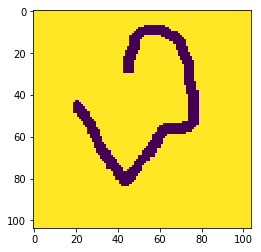

the shape of the image is 16121 x 1 x 104 x  104
the max of the image is 1.007874, the min of the image is -1.000000


In [12]:
f= np.load('omniglot.npz')
images= f['images']
images=images.astype('float')
images= (images-255/2)/(255/2)
images= np.reshape(images,(images.shape[0],1,images.shape[1],images.shape[1]))

plt.imshow(images[2].sum(axis=0))
plt.show()
print 'the shape of the image is %d x %d x %d x  %d' % images.shape
print 'the max of the image is %f, the min of the image is %f' % (images.max(),images.min())

In [23]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape((X_train.shape[0], 1) + X_train.shape[1:])
images.shape

(16121, 1, 104, 104)

In [26]:
def train(BATCH_SIZE):
    
    X_train = images
    discriminator = discriminator_model()
    generator = generator_model()
    discriminator_on_generator = \
        Generator_plus_discriminator(generator, discriminator)
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    #d_optim = Adam(lr=1e-4)
    #g_optim = Adam(lr=1e-3)
    generator.compile(loss='binary_crossentropy', optimizer="SGD")
    discriminator_on_generator.compile(
        loss='binary_crossentropy', optimizer=g_optim)
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer=d_optim)
    noise = np.zeros((BATCH_SIZE, 100)) 
    for epoch in (range(100)):
        print("Epoch is", epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        for index in tqdm(range(int(X_train.shape[0]/BATCH_SIZE))):
            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, 100)
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = generator.predict(noise, verbose=0)
            if index % 10 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                Image.fromarray(image.astype(np.uint8)).save(
                    str(epoch)+"_"+str(index)+".png")
            X = np.concatenate((image_batch, generated_images))
            y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
            d_loss = discriminator.train_on_batch(X, y)
            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, 100)
            discriminator.trainable = False
            g_loss = discriminator_on_generator.train_on_batch(
                noise, [1] * BATCH_SIZE)
            discriminator.trainable = True
            
            if index % 10 == 9:

                generator.save_weights('generator', True)
                discriminator.save_weights('discriminator', True)



# Training part 

G=generator_model()
D=discriminator_model()
discriminator_on_generator =  Generator_plus_discriminator(G,D)
generator_opti=SGD(lr=5e-3,momentum=0.9,nesterov=True)
discrim=SGD(lr=5e-3,momentum=0.9,nesterov=True)

G.compile(loss='binary_crossentropy',optimizer='SGD')
discriminator_on_generator.compile(loss='binary_crossentropy', optimizer=generator_opti)
D.trainable = True
D.compile(loss='binary_crossentropy',optimizer=discrim)
batch_size= 16

for epoch in (range(100)):
    print "Epoch is  = %d" %epoch
    print 'total batch = %d' % int(images.shape[0]/batch_size)
    for index in tqdm(range(int(images.shape[0]/64))):
        noise = np.random.uniform(-1,1,batch_size*100)
        noise =np.reshape(noise,(batch_size,100))
        image_batch = images[index*batch_size:index*batch_size+batch_size]
        #print str(image_batch.shape)
        generated_images = G.predict(noise,verbose=0)
        if index % 10 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                Image.fromarray(image.astype(np.uint8)).save(
                    str(epoch)+"_"+str(index)+".png")
        X = np.concatenate((image_batch, generated_images))
        y = [1] * batch_size + [0] * batch_size
        d_loss = D.train_on_batch(X, y)
        noise = np.random.uniform(-1,1,batch_size*100)
        noise =np.reshape(noise,(batch_size,100))
        D.trainable = False
        g_loss = discriminator_on_generator.train_on_batch(noise, [1] * batch_size)
        D.trainable = True
        if (index % 20)==0:
            print("batch %d d_loss : %f" % (index, d_loss))
            print("batch %d g_loss : %f" % (index, g_loss))

In [29]:
train(BATCH_SIZE=16)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               51712     
_________________________________________________________________
activation_37 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 5408)              2774304   
_________________________________________________________________
batch_normalization_5 (Batch (None, 5408)              21632     
_________________________________________________________________
activation_38 (Activation)   (None, 5408)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 32, 13, 13)        0         
_________________________________________________________________
up_sampling2d_13 (UpSampling (None, 32, 26, 26)        0         
__________

ResourceExhaustedError: OOM when allocating tensor with shape[36864,512]
	 [[Node: gradients_2/dense_17/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, _class=["loc:@dense_17/MatMul"], transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](flatten_5/Reshape, gradients_2/activation_35/Tanh_grad/TanhGrad)]]

Caused by op u'gradients_2/dense_17/MatMul_grad/MatMul_1', defined at:
  File "/home/hongbin/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/hongbin/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-e7fce88f170c>", line 1, in <module>
    train(BATCH_SIZE=25)
  File "<ipython-input-26-b5e592f7040f>", line 32, in train
    d_loss = discriminator.train_on_batch(X, y)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/models.py", line 944, in train_on_batch
    class_weight=class_weight)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/engine/training.py", line 1632, in train_on_batch
    self._make_train_function()
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/engine/training.py", line 1013, in _make_train_function
    self.total_loss)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/optimizers.py", line 128, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/optimizers.py", line 47, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 2264, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 560, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 368, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 560, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/math_grad.py", line 784, in _MatMulGrad
    grad_b = math_ops.matmul(a, grad, transpose_a=True)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 1801, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1263, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

...which was originally created as op u'dense_17/MatMul', defined at:
  File "/home/hongbin/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
[elided 19 identical lines from previous traceback]
  File "<ipython-input-29-e7fce88f170c>", line 1, in <module>
    train(BATCH_SIZE=25)
  File "<ipython-input-26-b5e592f7040f>", line 4, in train
    discriminator = discriminator_model()
  File "<ipython-input-6-c9e674061f26>", line 13, in discriminator_model
    model.add(Dense(512))
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/models.py", line 466, in add
    output_tensor = layer(self.outputs[0])
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 585, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/layers/core.py", line 840, in call
    output = K.dot(inputs, self.kernel)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 936, in dot
    out = tf.matmul(x, y)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 1801, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1263, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[36864,512]
	 [[Node: gradients_2/dense_17/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, _class=["loc:@dense_17/MatMul"], transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](flatten_5/Reshape, gradients_2/activation_35/Tanh_grad/TanhGrad)]]


In [ ]:
x.shape